In [2]:
import os, sys, pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from gail.gail import GAILTrainer
from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder, get_flow_params

import gym, ray
from ray.rllib.agents.ppo import PPOAgent, DEFAULT_CONFIG
from ray.rllib.agents.ddpg import DDPGAgent, DEFAULT_CONFIG
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print

benchmark_name = 'multi_merge'

exp_name = None
AGENT = 'GAIL'
if AGENT == 'GAIL':
    exp_name = 'latest_gail'
elif AGENT == 'PPO':
    exp_name = 'latest'
    
checkpoint = '150'
num_cpus = 60
num_trials = 50

benchmark = __import__(
    "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.gail_flow_params

In [3]:
ray.init(num_cpus=num_cpus, include_webui=False, ignore_reinit_error=True)

2019-06-03 02:13:52,432	INFO node.py:469 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-06-03_02-13-52_60683/logs.
2019-06-03 02:13:52,558	INFO services.py:407 -- Waiting for redis server at 127.0.0.1:18896 to respond...
2019-06-03 02:13:52,710	INFO services.py:407 -- Waiting for redis server at 127.0.0.1:21736 to respond...
2019-06-03 02:13:52,715	INFO services.py:804 -- Starting Redis shard with 10.0 GB max memory.
2019-06-03 02:13:52,785	INFO node.py:483 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-06-03_02-13-52_60683/logs.
2019-06-03 02:13:52,788	INFO services.py:1427 -- Starting the Plasma object store with 18.23 GB memory using /dev/shm.


{'node_ip_address': '10.138.0.2',
 'object_store_address': '/tmp/ray/session_2019-06-03_02-13-52_60683/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2019-06-03_02-13-52_60683/sockets/raylet',
 'redis_address': '10.138.0.2:18896',
 'webui_url': None}

In [4]:
GAIL_PATH = 'GAILTrainer_MultiWaveAttenuationMergePOEnvGAIL-v0_3_discrim_lr=0.005_2019-05-31_00-57-4510ppymby'

In [5]:
PATH = ''
if AGENT == 'GAIL':
    PATH = exp_name + '/' + GAIL_PATH
    
config_path = '/headless/rl_project/ray_results/' + PATH + '/params.pkl'
checkpoint_path = '/headless/rl_project/ray_results/' + PATH + '/checkpoint_{}/checkpoint-{}'.format(checkpoint, checkpoint)

with open(config_path, mode='rb') as f:
    config = pickle.load(f)
config["expert_path"] = '/headless/rl_project/flow_codes/InverseRL/expert_sample'
flow_params = get_flow_params(config)
create_env, env_name = make_create_env(params=flow_params, version=0)
env = create_env()
left_length = env.k.scenario.edge_length('left')
car_length = 5.0
scale = 10

# Register as rllib env
register_env(env_name, create_env)

In [6]:
@ray.remote
def evaluate(create_env, AGENT, config=None, env_name=None, checkpoint_path=None):
    
    agent = None
    if AGENT == 'GAIL':
        agent = GAILTrainer(config=config, env=env_name)
        agent.restore(checkpoint_path)
        
    env = create_env()
    env.init_discriminator(128)
    env.set_state_dict(agent.discriminator.state_dict())

    left_length = env.k.scenario.edge_length('left')
    car_length = 5.0
    scale = 10
    
    # test until horizon
    state = env.reset()
    vel = []
    outflow = []
    for i in range(env.env_params.horizon):
        # record the mean velocity
        v = np.mean(env.k.vehicle.get_speed(env.k.vehicle.get_ids()))
        vel.append(v)

        # record the velocity map
        ids = env.k.vehicle.get_ids()
        vel_map_ = np.zeros(int(left_length)*scale)
        for id_ in ids:
            pos_ = np.round(env.k.vehicle.get_position(id_), decimals=1)
            vel_ = env.k.vehicle.get_speed(id_)
            pos_bottom = max(0, int((pos_-car_length/2.0)*scale))
            pos_top = min(int(left_length)*scale, int((pos_+car_length/2.0)*scale))
            if env.k.vehicle.get_edge(id_) == 'left':
                vel_map_[pos_bottom:pos_top] = vel_            

        # step the simulation
        rl_ids = env.k.vehicle.get_rl_ids()
        actions = {}
        if AGENT != 'HUMAN':
            for id_ in rl_ids:
                action = agent.compute_action(state[id_])
                actions.update({id_: action})
        state, r, _, _ = env.step(actions)
        outflow.append(env.k.vehicle.get_outflow_rate(100)) # measured by one min

        if i == 0:
            vel_map_list = vel_map_
        else:
            vel_map_list = np.vstack((vel_map_list, vel_map_))

    outflow = outflow[-500:]
    vel_map_list[vel_map_list==0.0] = np.nan

    return vel, outflow, vel_map_list

In [ ]:
%%time
results = ray.get([evaluate.remote(create_env, AGENT, config, env_name, checkpoint_path) for _ in range(num_trials)])

2019-06-03 02:13:55,150	WARNING worker.py:334 -- WARNING: Falling back to serializing objects of type <class 'numpy.dtype'> by using pickle. This may be inefficient.


(pid=60841) 2019-06-03 02:14:14,639	WARNING json_reader.py:52 -- Treating input directory as glob pattern: /headless/rl_project/flow_codes/InverseRL/expert_sample/*.json
(pid=60841) 2019-06-03 02:14:14,640	INFO json_reader.py:65 -- Found 1 input files.
(pid=60821) 2019-06-03 02:14:14,752	WARNING json_reader.py:52 -- Treating input directory as glob pattern: /headless/rl_project/flow_codes/InverseRL/expert_sample/*.json
(pid=60821) 2019-06-03 02:14:14,753	INFO json_reader.py:65 -- Found 1 input files.
(pid=60841) Loading configuration... done.
(pid=60841) Success.
(pid=60841) Loading configuration... done.
(pid=60821) Loading configuration... done.
(pid=60821) Success.
(pid=60821) Loading configuration... done.
(pid=60841) 2019-06-03 02:14:15,918	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
(pid=60841) 2019-06-03 02:14:15.920095: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that thi

(pid=60840) 2019-06-03 02:14:18,656	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
(pid=60840) 2019-06-03 02:14:18.658762: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=60866) 2019-06-03 02:14:18,802	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
(pid=60866) 2019-06-03 02:14:18.804410: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=60816) Loading configuration... done.
(pid=60816) Success.
(pid=60850) 2019-06-03 02:14:18,830	WARNING json_reader.py:52 -- Treating input directory as glob pattern: /headless/rl_project/flow_codes/InverseRL/expert_sample/*.json
(pid=60850) 2019-06-03 02:14:18,831	INFO json_reader.py:65 -- Found 1 input files.

(pid=60849) 2019-06-03 02:14:20,414	WARNING json_reader.py:52 -- Treating input directory as glob pattern: /headless/rl_project/flow_codes/InverseRL/expert_sample/*.json
(pid=60849) 2019-06-03 02:14:20,415	INFO json_reader.py:65 -- Found 1 input files.
(pid=60855) 2019-06-03 02:14:20,415	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
(pid=60855) 2019-06-03 02:14:20.417029: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=60816) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=60816)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=60839) Loading configuration... done.
(pid=60839) Success.
(pid=60848) 2019-06

(pid=60811) Loading configuration... done.
(pid=60857) Loading configuration... done.
(pid=60864) 2019-06-03 02:14:21,324	WARNING json_reader.py:52 -- Treating input directory as glob pattern: /headless/rl_project/flow_codes/InverseRL/expert_sample/*.json
(pid=60864) 2019-06-03 02:14:21,325	INFO json_reader.py:65 -- Found 1 input files.
(pid=60831) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=60831)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=60836) Loading configuration... done.
(pid=60858) 2019-06-03 02:14:21,328	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
(pid=60858) 2019-06-03 02:14:21.330204: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow bin

(pid=60866) Loading configuration... done.
(pid=60852) 2019-06-03 02:14:21,829	WARNING json_reader.py:52 -- Treating input directory as glob pattern: /headless/rl_project/flow_codes/InverseRL/expert_sample/*.json
(pid=60852) 2019-06-03 02:14:21,830	INFO json_reader.py:65 -- Found 1 input files.
(pid=60856) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=60856)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=60834) 2019-06-03 02:14:21,834	WARNING json_reader.py:52 -- Treating input directory as glob pattern: /headless/rl_project/flow_codes/InverseRL/expert_sample/*.json
(pid=60834) 2019-06-03 02:14:21,834	INFO json_reader.py:65 -- Found 1 input files.
(pid=60845) Success.
(pid=60814) 2019-06-03 02:14:21,825	WARNING json_reader.py:52 -- Treating input directory as glob pattern: /

(pid=60830) 2019-06-03 02:14:22,295	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
(pid=60830) 2019-06-03 02:14:22.297451: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=60855) 2019-06-03 02:14:22,291	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7febe35aea20>}
(pid=60855) 2019-06-03 02:14:22,291	INFO policy_evaluator.py:729 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7febe35ae6d8>}
(pid=60855) 2019-06-03 02:14:22,291	INFO policy_evaluator.py:343 -- Built filter map: {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x7febe35ae438>}
(pid=60817) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarni

(pid=60820) Loading configuration... done.
(pid=60813) 2019-06-03 02:14:22,752	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
(pid=60813) 2019-06-03 02:14:22.753881: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=60809) Loading configuration... done.
(pid=60809) Success.
(pid=60863) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=60863)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=60867) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of 

(pid=60844) Loading configuration... done.
(pid=60844) Success.
(pid=60837) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=60837)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=60844) Loading configuration... done.
(pid=60864) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=60864)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=60851) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=60851) 

(pid=60825) 2019-06-03 02:14:23,710	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7f373c418a90>}
(pid=60825) 2019-06-03 02:14:23,710	INFO policy_evaluator.py:729 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f373c418748>}
(pid=60825) 2019-06-03 02:14:23,710	INFO policy_evaluator.py:343 -- Built filter map: {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x7f373c4184a8>}
(pid=60856) Loading configuration... done.
(pid=60833) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=60833)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=60846) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients

(pid=60817) Loading configuration... done.
(pid=60830) 2019-06-03 02:14:24,637	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7f57f4aaea90>}
(pid=60830) 2019-06-03 02:14:24,637	INFO policy_evaluator.py:729 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f57f4aae748>}
(pid=60830) 2019-06-03 02:14:24,637	INFO policy_evaluator.py:343 -- Built filter map: {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x7f57f4aae4a8>}
(pid=60862) 2019-06-03 02:14:24,664	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7fe121397a58>}
(pid=60862) 2019-06-03 02:14:24,664	INFO policy_evaluator.py:729 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fe1213976a0>}
(pid=60862) 2019-06-03 02:14:24,664	INFO policy_ev

(pid=60863) Success.
(pid=60819) Loading configuration... done.
(pid=60819) Success.
(pid=60844) 2019-06-03 02:14:25,099	INFO tf_run_builder.py:89 -- Executing TF run without tracing. To dump TF timeline traces to disk, set the TF_TIMELINE_DIR environment variable.
(pid=60858) Loading configuration... done.
(pid=60813) 2019-06-03 02:14:25,092	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7f3d008f1a90>}
(pid=60813) 2019-06-03 02:14:25,092	INFO policy_evaluator.py:729 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f3d008f1748>}
(pid=60813) 2019-06-03 02:14:25,092	INFO policy_evaluator.py:343 -- Built filter map: {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x7f3d008f14a8>}
(pid=60846) 2019-06-03 02:14:25,163	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGr

(pid=60811) Loading configuration... done.
(pid=60825) Loading configuration... done.
(pid=60825) Success.
(pid=60859) Loading configuration... done.
(pid=60807) Loading configuration... done.
(pid=60807) Success.
(pid=60865) Loading configuration... done.
(pid=60854) Loading configuration... done.
(pid=60854) Success.
(pid=60828) Loading configuration... done.
(pid=60828) Success.
(pid=60810) Loading configuration... done.
(pid=60810) Success.
(pid=60825) Loading configuration... done.
(pid=60807) Loading configuration... done.
(pid=60837) Loading configuration... done.
(pid=60833) Loading configuration... done.
(pid=60854) Loading configuration... done.
(pid=60828) Loading configuration... done.
(pid=60810) Loading configuration... done.
(pid=60815) Loading configuration... done.
(pid=60815) Success.
(pid=60833) Success.
(pid=60855) 2019-06-03 02:14:26,036	INFO tf_run_builder.py:89 -- Executing TF run without tracing. To dump TF timeline traces to disk, set the TF_TIMELINE_DIR enviro

(pid=60824) 2019-06-03 02:14:27,958	INFO tf_run_builder.py:89 -- Executing TF run without tracing. To dump TF timeline traces to disk, set the TF_TIMELINE_DIR environment variable.
(pid=60863) 2019-06-03 02:14:27,991	INFO tf_run_builder.py:89 -- Executing TF run without tracing. To dump TF timeline traces to disk, set the TF_TIMELINE_DIR environment variable.
(pid=60819) 2019-06-03 02:14:28,068	INFO tf_run_builder.py:89 -- Executing TF run without tracing. To dump TF timeline traces to disk, set the TF_TIMELINE_DIR environment variable.
(pid=60867) 2019-06-03 02:14:28,412	INFO tf_run_builder.py:89 -- Executing TF run without tracing. To dump TF timeline traces to disk, set the TF_TIMELINE_DIR environment variable.
(pid=60851) 2019-06-03 02:14:28,625	INFO tf_run_builder.py:89 -- Executing TF run without tracing. To dump TF timeline traces to disk, set the TF_TIMELINE_DIR environment variable.
(pid=60862) 2019-06-03 02:14:28,762	INFO tf_run_builder.py:89 -- Executing TF run without traci

In [ ]:
vel_list = []
outflow_list = []
vel_map_lists = []
for vel, outflow, vel_map_list in results:
    vel_list.append(vel)
    outflow_list.append(outflow)
    vel_map_lists.append(vel_map_list)
vel_mean = np.mean(vel_list, axis=0)
outflow_mean = np.mean(outflow_list, axis=0)
vel_map_mean = np.nanmean(vel_map_lists, axis=0)      

In [ ]:
data_path = "/headless/rl_project/flow_codes/data/"

try:
    np.save(data_path + 'gail_trained_'+str(num_trials)+'_vel.npy', vel_mean)
    np.save(data_path + 'gail_trained_'+str(num_trials)+'_outflow.npy', outflow_mean)
    np.save(data_path + 'gail_trained_'+str(num_trials)+'_vel_map.npy', vel_map_mean)
except:
    vel_mean = np.load(data_path + 'gail_trained_'+str(num_trials)+'_vel.npy')
    outflow_mean = np.load(data_path + 'gail_trained_'+str(num_trials)+'_outflow.npy')
    vel_map_mean = np.load(data_path + 'gail_trained_'+str(num_trials)+'_vel_map.npy')

human_vel_mean = np.load(data_path + 'human_'+str(num_trials)+'_vel.npy')
human_outflow_mean = np.load(data_path + 'human_'+str(num_trials)+'_outflow.npy')
human_vel_map_mean = np.load(data_path + 'human_'+str(num_trials)+'_vel_map.npy')

ppo_vel_mean = np.load(data_path + 'ppo_trained_'+str(num_trials)+'_vel.npy')
ppo_outflow_mean = np.load(data_path + 'ppo_trained_'+str(num_trials)+'_outflow.npy')
ppo_vel_map_mean = np.load(data_path + 'ppo_trained_'+str(num_trials)+'_vel_map.npy')

In [ ]:
print('\n mean velocity [human: {:.1f}, ppo: {:.1f}, gail: {:.1f}]'.format(np.mean(human_vel_mean), 
                                                           np.mean(ppo_vel_mean),
                                                           np.mean(vel_mean)))
print(' \n mean outflow rate [human: {:.1f}, ppo: {:.1f}, gail: {:.1f}]'.format(np.mean(human_outflow_mean),
                                                                                np.mean(ppo_outflow_mean),
                                                                                np.mean(outflow_mean)))

In [ ]:
vel_fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(ppo_vel_mean)
ax.plot(human_vel_mean)
ax.plot(vel_mean)
title = AGENT + ' multi-agent mean velocity'+str(num_trials)+'  trials'
ax.set_ylim((0, 25))
ax.set_ylabel('system level mean velocity (m/s)')
ax.set_xlabel('step')
ax.legend(['expert', 'NoRL', 'GAIL'])
vel_fig.suptitle(title)
plt.subplots_adjust(top=0.8)

In [ ]:
outflow_fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(ppo_outflow_mean)
ax.plot(human_outflow_mean)
ax.plot(outflow_mean)
title = AGENT + ' multi-agent mean outflow '+ str(num_trials) +' trials'
ax.set_ylabel('outflow veh/hr')
ax.set_xlabel('step')
ax.set_ylim([1000, 1700])
ax.legend(['expert', 'NoRL', 'GAIL'])
outflow_fig.suptitle(title)
#plt.subplots_adjust(top=0.8)


(pid=10867) Note, this may print an error message when it closes.
(pid=10811) Closing connection to TraCI and stopping simulation.
(pid=10811) Note, this may print an error message when it closes.
(pid=10868) Closing connection to TraCI and stopping simulation.
(pid=10868) Note, this may print an error message when it closes.
(pid=10812) Closing connection to TraCI and stopping simulation.
(pid=10812) Note, this may print an error message when it closes.
(pid=10844) Closing connection to TraCI and stopping simulation.
(pid=10844) Note, this may print an error message when it closes.
(pid=10833) Closing connection to TraCI and stopping simulation.
(pid=10833) Note, this may print an error message when it closes.
(pid=14812) Closing connection to TraCI and stopping simulation.
(pid=14812) Note, this may print an error message when it closes.
(pid=10829) Closing connection to TraCI and stopping simulation.
(pid=10829) Note, this may print an error message when it closes.
(pid=10842) Clos

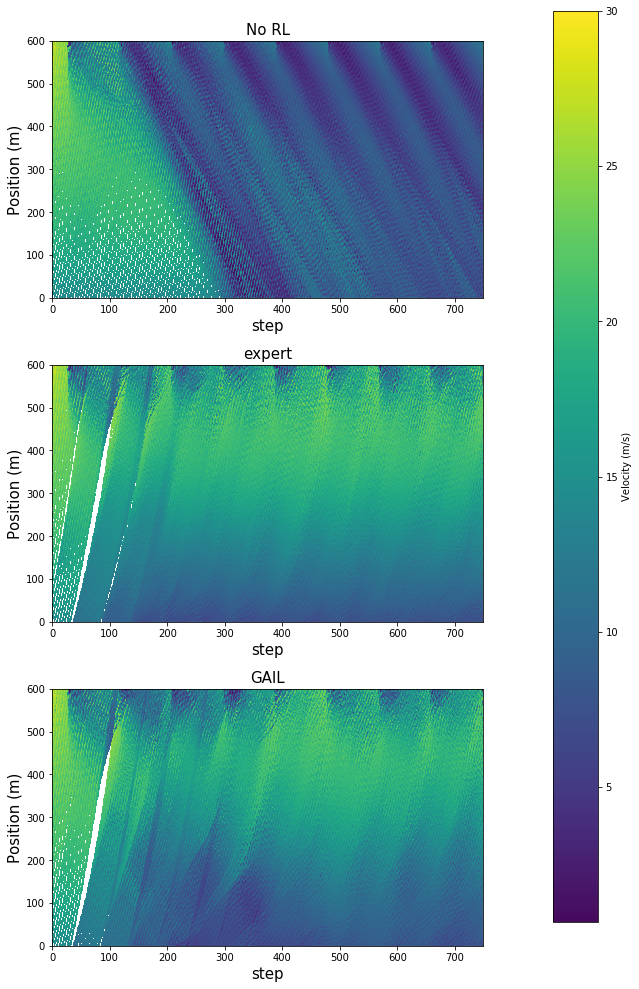

In [13]:
space_fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
space_fig.tight_layout(pad=5.0)

x = np.arange(int(750))
y = np.arange(0, int(600), step=0.1)
xx, yy = np.meshgrid(x, y)

# No RL
im = axes[0].pcolormesh(xx, yy, human_vel_map_mean.T)
axes[0].set_ylabel('Position (m)', fontsize=15.0)
axes[0].set_xlabel('step', fontsize=15.0)
axes[0].set_title('No RL', fontsize=15.0)

# RL
im = axes[1].pcolormesh(xx, yy, ppo_vel_map_mean.T)
axes[1].set_ylabel('Position (m)', fontsize=15.0)
axes[1].set_xlabel('step', fontsize=15.0)
axes[1].set_title('expert', fontsize=15.0)

# gail
im = axes[2].pcolormesh(xx, yy, vel_map_mean.T)
axes[2].set_ylabel('Position (m)', fontsize=15.0)
axes[2].set_xlabel('step', fontsize=15.0)
axes[2].set_title('GAIL', fontsize=15.0)

clb = space_fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
clb.set_clim(0, 30)
clb.set_label('Velocity (m/s)')
title = AGENT + ' Space-Time Diagram of 600 meter merge road'
# space_fig.suptitle(title)   
plt.subplots_adjust(top=0.9, right=0.7)

In [14]:
result_path = "/headless/rl_project/flow_codes/result/"

vel_filename = 'compare_trained_human_vel_'+str(num_trials)+'.png'
outflow_filename = 'compare_trained_human_outflow_'+str(num_trials)+'.png'
congestion_filename = 'compare_trained_human_congestion_'+str(num_trials)+'.png'
dir_path = result_path + 'MultiMerge/' + AGENT + '/' + exp_name + '/'+str(num_trials)+'/'
os.makedirs(dir_path, exist_ok=True)
vel_fig.savefig(dir_path + vel_filename)
outflow_fig.savefig(dir_path + outflow_filename)
space_fig.savefig(dir_path + congestion_filename)